# **Análisis de datos**
## **Tarea 10**
## **Ana Isabel Moreno Hernández**

-------------------------------------------------------------------------------

**Importamos las librerías necesarias:**

In [208]:
from __future__ import print_function
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.integrate import trapz, simps
import math
import random
%matplotlib inline

**Importamos la librería colossus, la cual fue descargada utilizando el comando pip install colosus en la terminal.**

In [209]:
from colossus.cosmology import cosmology

**Inicializamos la clase e imprimimos los parámetros definidos por el experimento Planck:**

In [210]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [211]:
cosmo.Om0 = 0.29 # Densidad de materia total
cosmo.Omde = 0.71 # Densidad de energía
cosmo.ns = 0.97 # Pendiente original del espectro de potencias
cosmo.H0 = 70 # Factor da la expansión del universo

cosmo.relspecies = False # No hay especies relativas extra
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "planck15" 
    flat = True, Om0 = 0.2900, Ode0 = 0.7100, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9700
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


**La función se grafica utilizando la clase matterPowerSpectrum(k,z) que depende dos parámetros y los otros 4 anteriormente mencionados.**

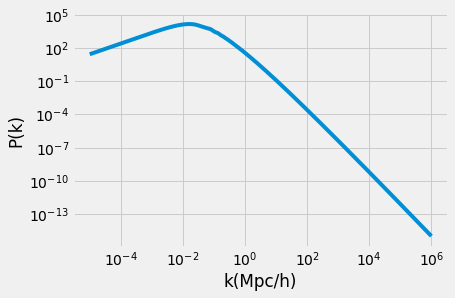

In [212]:
k = 10**np.linspace(-5,6,100000)

# z = 0.57
Pk = cosmo.matterPowerSpectrum(k,0.57)

plt.style.use('fivethirtyeight')
plt.figure()
plt.loglog() # Escala logarítmica
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-')
plt.grid('True')

In [213]:
Pk_ = cosmo.matterPowerSpectrum

**Ahora graficamos los datos y la función $1.85^2$PowerSpectrum, que es la que mejor se ajusta a los datos.**

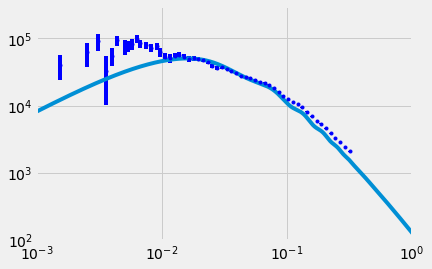

In [222]:
# Datos
pk_cmasdr12 = np.loadtxt('GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
plt.plot(k, 1.85**2*Pk, '-')
plt.xlim(1e-3,1)
plt.ylim(100, 3e5)
plt.grid('True')

**A continuación definiremos la función Pk_Om que cambia el parámetro de densidad de materia total y recibe como argumento el nuevo valor de Om0 y el valor de la constante $b$ que se eleva al cuadrado y multiplica a la función matterPowerSpectrum.**

In [223]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,k):
    z =0.57
    cosmo.Om0 = Om_
    return b**2*cosmo.matterPowerSpectrum(k,z)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


**Observamos cómo cambia la función al modificar la densidad de materia y el bias**

(100, 3000000.0)

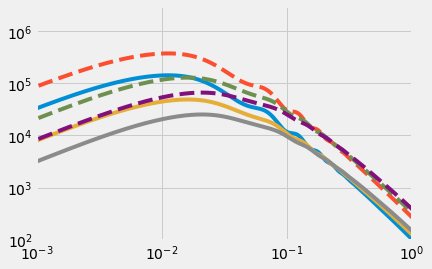

In [224]:
plt.figure()
plt.loglog()

OM = (0.2,0.3,0.4)
for om in OM:
    plt.plot(k,Pk_Om(om,1.85,k), '-') # Sin bias
    plt.plot(k,Pk_Om(om,3,k), '--')
    

plt.xlim(1e-3,1)
plt.ylim(100,3e6)

## **Utilizamos metrópolis para encontrar la función que mejor se ajuste**

**Empezamos con un camino para observar si nuestras funciones se ajustan a los datos.**
**Variamos el parámetro $Om0$ entre 0.1 y 0.5, y el bias $b$ entre 1 y 3.**

In [225]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

def likelihood(Om, b, data): # Función que calcula el logaritmo natural del likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, equis) # Calculamos el modelo utilizando la función Pk_om
    likelihood_0 = (ye-model)**2/(yerr**2)  # Obtenemos chi^2
    return likelihood_0.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [226]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

rango = 2000 # Establecemos un rango de 2000

Om_0 = 0.4 # Damos un valor inicial para la densidad de materia
b0 = 2.2 # Valor inicial para el bias
lnlike0 = -1*likelihood(Om_0, b0, [x,y,yerror]) # Calculamos el logaritmo natural del primer likelihood 

Om_sample = [Om_0] # Guardamos el primer valor de la densidad de mateira
b_sample = [b0] # Guardamos el primer valor del bias

sigma = 0.01 # Establecemos un valor para la desviación estándar de los caminos en el método de metrópolis

for j in range(1,rango):
    Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Generamos un valor de densidad de materia nuevo de una probabilidad gaussiana con mediana igual al valor anterior de Om0 y con desviación estándar sigma.
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    if Om_new <= 0.5 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1: # Establecemos el prior
        like = -1*likelihood(Om_new, b_new, [x,y,yerror])
        if like>lnlike0: # Si el logaritmo natural del nuevo likelihood es mayor que el anterior, se acepta
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0 y b
            b_sample.append(b_new)
        elif lnlike0-like<-1*math.log(random.uniform(0,1)): # Si la diferencia es menor que el negativo del logaritmo de un número aletorio de una distribución uniforme, se acepta.
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0 y b
            b_sample.append(b_new)

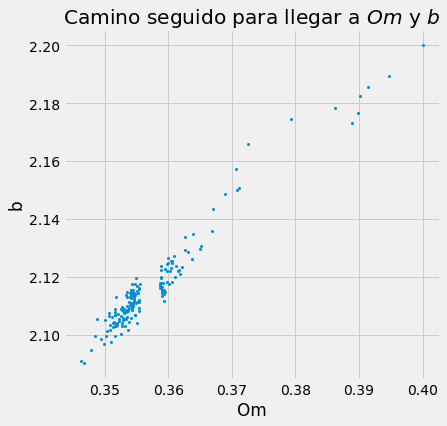

In [227]:
plt.figure(figsize = (6,6))
plt.plot(Om_sample,b_sample, 'o', markersize = 2) # Graficamos el camino seguido para llegar a Om0 y b y observamos si nuestro método función
plt.xlabel('Om')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $Om$ y $b$')
plt.grid('True')

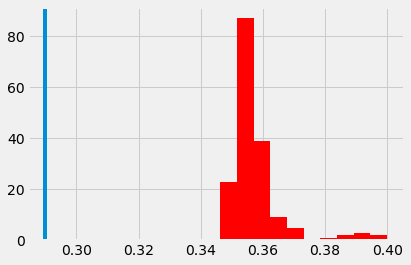

In [228]:
plt.hist(Om_sample, color = 'red')
plt.axvline(0.29)

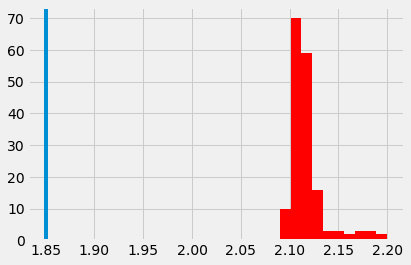

In [229]:
plt.hist(b_sample, color = 'red')
plt.axvline(1.85)

**Observamos que con un camino nuestro método funciona, así que ahora lo generalizamos y utilizamos más de uno.**

### **Varios caminos:**

In [230]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 1000

for k in range(10): # 10 caminos
    Om_0 = np.random.uniform(0.1, 0.7, 10) # Los valores iniciales para cada camino se generarán con números aleatorios de una distribución uniforme
    b0 = np.random.uniform(1, 3, 10) # Lo mismo para el bias
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    lnlike0 = -1*likelihood(Om_0[k], b0[k], [x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        if Om_new <= 0.7 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1: # Prior
            like = -1*likelihood(Om_new, b_new, [x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)

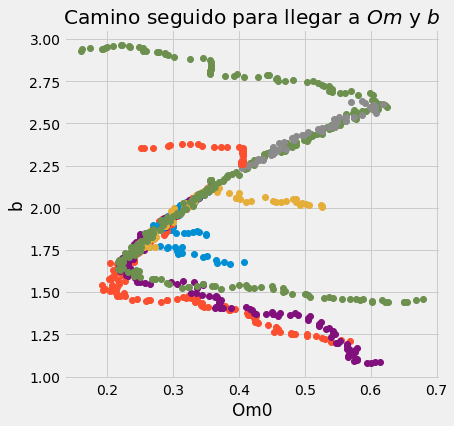

In [231]:
plt.figure(figsize = (6,6))
for k in range(10):
    plt.plot(Om_total[k],b_total[k], 'o')
    

plt.xlabel('Om0')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $Om$ y $b$')
plt.grid('True')

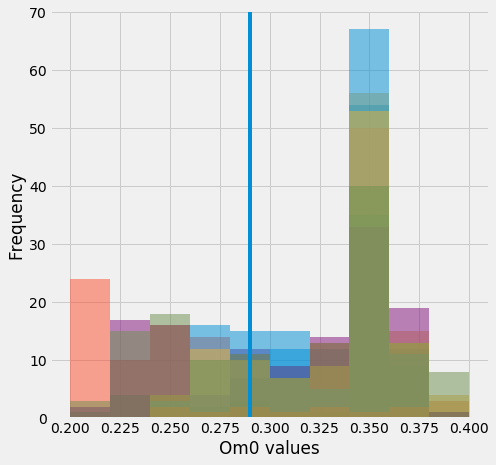

In [232]:
plt.figure(figsize = (7,7))
for i in range(10):
    plt.hist(Om_total[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

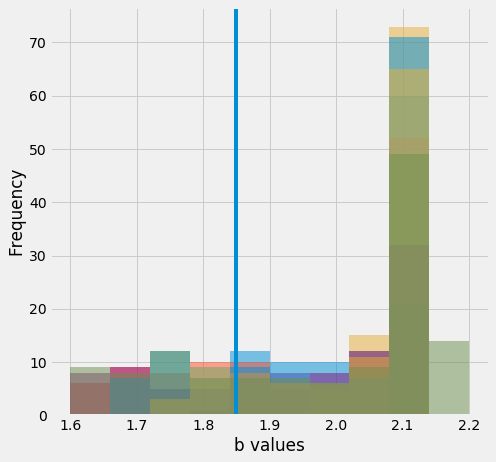

In [233]:
plt.figure(figsize = (7,7))
for i in range(10):
    plt.hist(b_total[i], range = (1.6,2.2) ,alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

**Usamos el método de Gelman-Rubin para determinar si las cadenas han convergido.Referencia: https://arxiv.org/pdf/1812.09384.pdf**

In [234]:
n = 10 # Número de caminos

def prom_x_i(x_it):
    return np.mean(x_it) # Promedio de un camino

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i]) # Promedio de todos los caminos
    return sum/n

def s_i2(x_it):
    return np.std(x_it) # Desviación estándar de un camino

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i]) # Desviación estándar de todos los caminos
    return sum/n

def B_n(x_i): # Parámetro Bn
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):  
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m): # Parámetro R
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [235]:
R(Om_total, len(Om_total[0]))

1.0139872211993737

In [236]:
R(b_total, len(b_total[0]))

1.203356799901105

Notamos que el parámetro R para Om_total es muy cercano a 1, mientras que el de b está un poco alejado. 

**Quitamos el burning:**

In [246]:
Om_new = []
b_new = []

burn = 100
for i in range(10):
    if(len(Om_total[i])>burn and len(b_total[i])>burn):
        Om_new.append(Om_total[i][burn:])
        b_new.append(b_total[i][burn:])

In [247]:
len(Om_new) # Vemos cuántos caminos tienen más de 100 puntos

6

In [248]:
n = len(Om_new)
R(Om_new, len(Om_new[0]))

1.0107326564177699

In [249]:
R(b_new, len(b_new[0]))

1.0357143629196799

**Volvemos a graficar sin el burning**

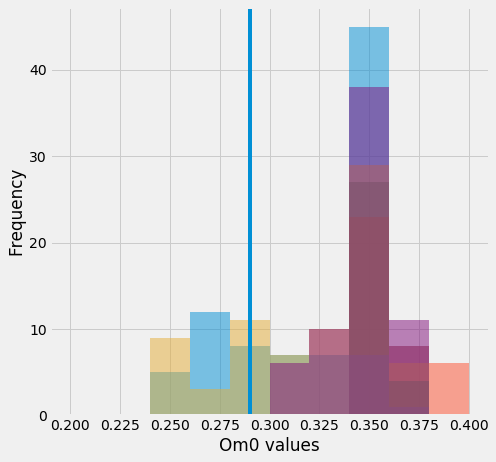

In [251]:
plt.figure(figsize = (7,7))
for i in range(len(Om_new)):
    plt.hist(Om_new[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

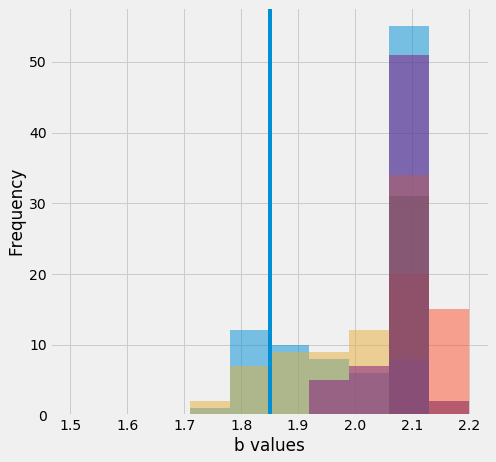

In [253]:
plt.figure(figsize = (7,7))
for i in range(len(b_new)):
    plt.hist(b_new[i], range = (1.5,2.2),alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

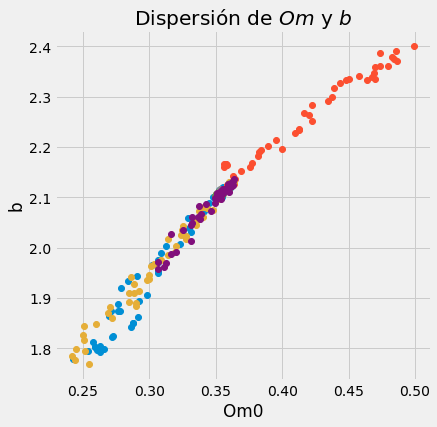

In [254]:
plt.figure(figsize = (6,6))
for k in range(len(b_new)):
    plt.plot(Om_new[k],b_new[k], 'o')
    

plt.xlabel('Om0')
plt.ylabel('b')
plt.title('Dispersión de $Om$ y $b$')
plt.grid('True')

**Utilizamos corner para observar las distribuciones de Om0 y b:**

In [269]:
import corner

In [276]:
Om_array = np.array(Om_new[0])
b_array = np.array(b_new[0])

samples = np.array([Om_array, b_array])

samples = samples.T

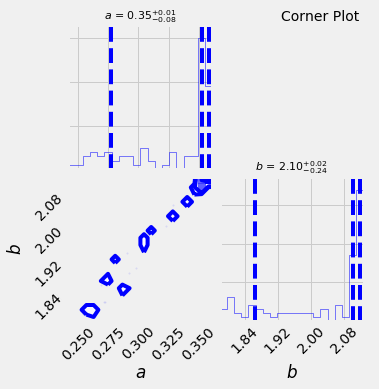

In [280]:
# Make the base corner plot

figure = corner.corner(samples, color = 'blue',labels=[r"$a$", r"$b$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 11})
figure.gca().annotate("Corner Plot",
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-20, -10), textcoords="offset points",
                      ha="right", va="top");

**Calculamos medianas**

In [255]:
from statistics import median

In [257]:
mediana0 = []

for i in range(len(Om_new)):
    mediana0.append(np.median(Om_new[i]))

In [258]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i]))

**Imprimimos los valores de las medianas:**

In [266]:
Om0 = median(mediana0)
be = median(medianab)
print(be, Om0)

2.1090811293071208 0.3529141542806622


También podemos observar hacia qué valor convergen los caminos:

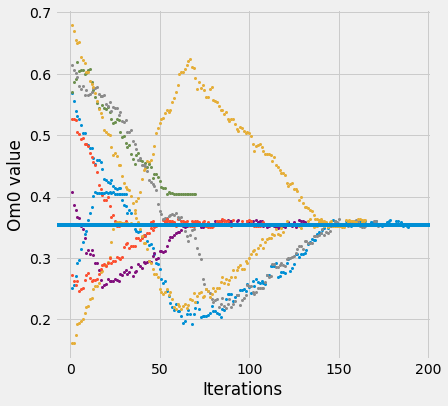

In [288]:
plt.figure(figsize = (6,6))

for i in range(1,len(Om_total)):
    iteraciones = np.linspace(1, len(Om_total[i]), len(Om_total[i]))
    plt.plot(iteraciones, Om_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(Om0)
plt.ylabel('Om0 value');


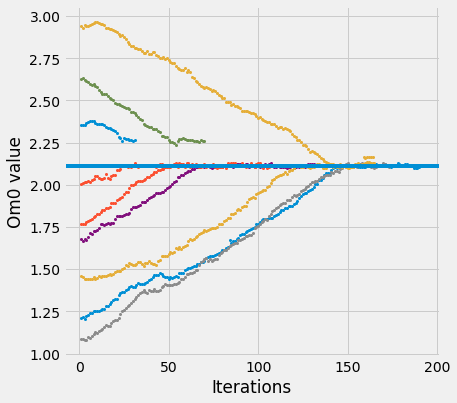

In [292]:
plt.figure(figsize = (6,6))

for i in range(1,len(b_total)):
    iteraciones = np.linspace(1, len(b_total[i]), len(b_total[i]))
    plt.plot(iteraciones, b_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(be)
plt.ylabel('Om0 value');

**Finalmente, graficamos y vemos qué tan bien nuestro modelo se ajusta a los datos.**

Text(0, 0.5, 'P(k)')

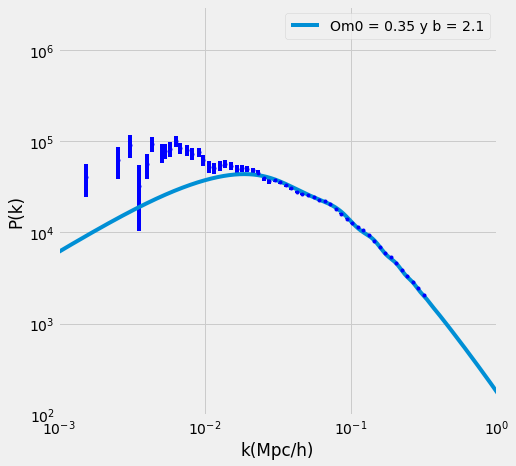

In [289]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35 y b = 2.1') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')